In [12]:
import sklearn, numpy
print("sklearn:", sklearn.__version__, "| numpy:", numpy.__version__)

sklearn: 1.1.3 | numpy: 1.23.5


In [13]:
import pandas as pd

# Load the training and testing sets
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

# Verify the shapes to confirm successful loading
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5716, 6)
X_test shape: (1430, 6)
y_train shape: (5716, 1)
y_test shape: (1430, 1)


In [14]:
# Display the first few rows of the training data
print("First few rows of X_train:")
print(X_train.head())

print("\nFirst few rows of y_train:")
print(y_train.head())

First few rows of X_train:
   bedrooms  accommodates  review_scores_rating  room_type_Private room  \
0       1.0           2.0                  96.0                       0   
1       4.0           8.0                 100.0                       0   
2       1.0           2.0                  81.0                       1   
3       1.0           2.0                  80.0                       0   
4       3.0           7.0                 100.0                       0   

   bathrooms  room_type_Shared room  
0        1.0                      0  
1        3.5                      0  
2        1.0                      0  
3        1.0                      0  
4        1.5                      0  

First few rows of y_train:
   log_price
0   4.795791
1   6.304449
2   4.189655
3   4.844187
4   5.786897


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Initialize models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Dictionary to hold models
models = {'Linear Regression': lr, 'Decision Tree': dt, 'Random Forest': rf, 'Gradient Boosting': gb}

# Train each model and evaluate
for name, model in models.items():
    model.fit(X_train, y_train.values.ravel())  # Convert y_train to 1D array
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test.values.ravel(), y_pred)  # Convert y_test to 1D array
    print(f"{name} - MSE: {mse:.4f}")

Linear Regression - MSE: 0.2080
Decision Tree - MSE: 0.2497
Random Forest - MSE: 0.2062
Gradient Boosting - MSE: 0.1897


In [16]:
from sklearn.model_selection import GridSearchCV

# Tuning Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10]
}

grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_gb.fit(X_train, y_train.values.ravel())

# Best parameters and score
print("Best Parameters for Gradient Boosting:", grid_search_gb.best_params_)
print("Best CV Score for Gradient Boosting:", -grid_search_gb.best_score_)

Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Score for Gradient Boosting: 0.21203240531466613


In [17]:
# Tuning Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train.values.ravel())

# Best parameters and score
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("Best CV Score for Random Forest:", -grid_search_rf.best_score_)


Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best CV Score for Random Forest: 0.21502721028418487


In [18]:
# Evaluate Gradient Boosting on Test Set
final_gb = grid_search_gb.best_estimator_
gb_test_pred = final_gb.predict(X_test)
gb_test_mse = mean_squared_error(y_test.values.ravel(), gb_test_pred)
print(f"Gradient Boosting Test MSE: {gb_test_mse:.4f}")

# Evaluate Random Forest on Test Set
final_rf = grid_search_rf.best_estimator_
rf_test_pred = final_rf.predict(X_test)
rf_test_mse = mean_squared_error(y_test.values.ravel(), rf_test_pred)
print(f"Random Forest Test MSE: {rf_test_mse:.4f}")

Gradient Boosting Test MSE: 0.1897
Random Forest Test MSE: 0.1912


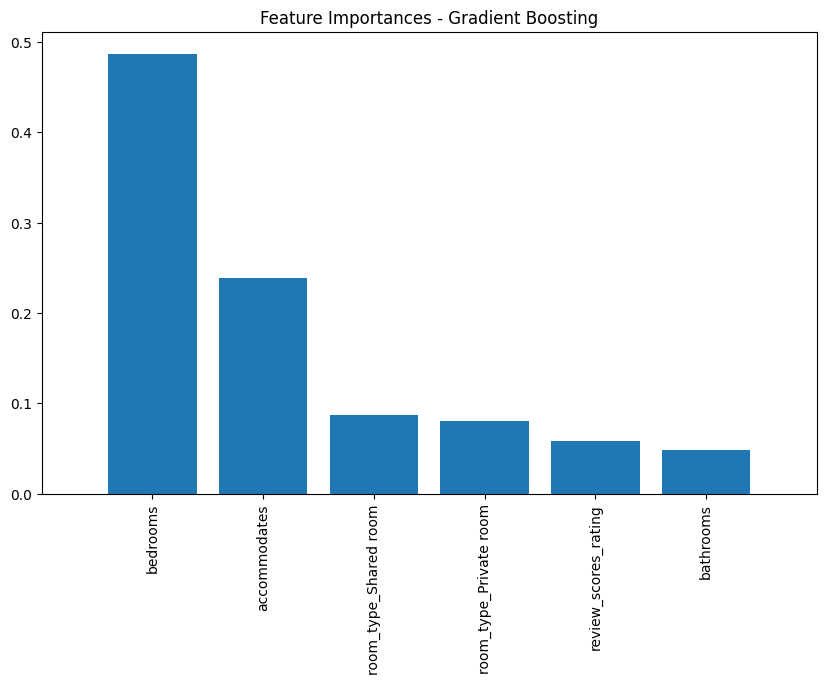

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importances from the final Gradient Boosting model
importances = final_gb.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances - Gradient Boosting")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [20]:
import cloudpickle

with open('final_model_cloudpickle.pkl', 'wb') as f:
    cloudpickle.dump(final_gb, f)

# Confirm the model is saved
print("Final Gradient Boosting model saved as 'final_model_cloudpickle.pkl'")

Final Gradient Boosting model saved as 'final_model_cloudpickle.pkl'


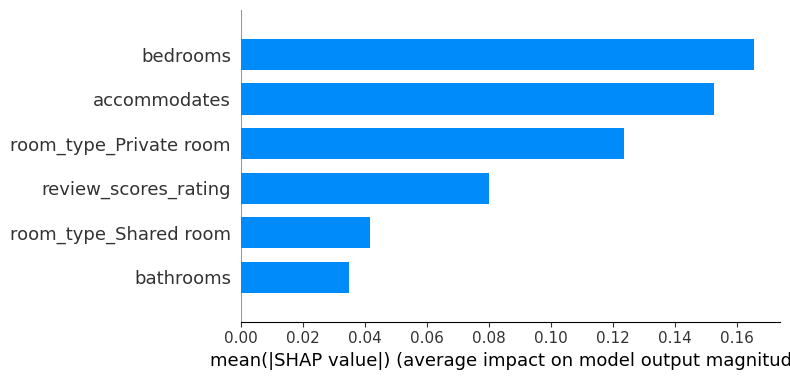

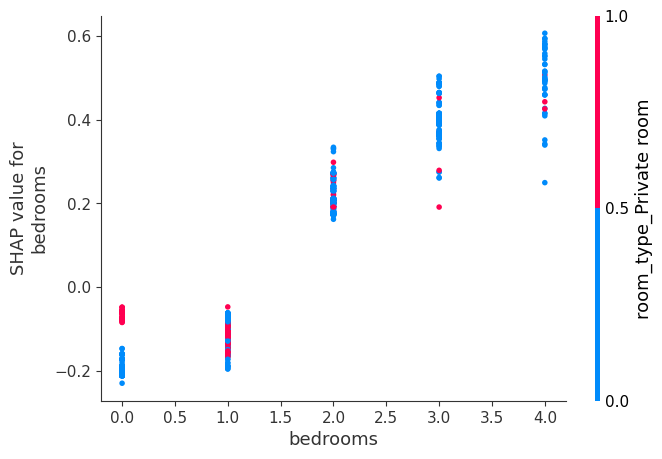

In [21]:
import shap

# Initialize SHAP explainer using the final Gradient Boosting model
explainer = shap.TreeExplainer(final_gb)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot summary of SHAP values to see the overall feature importance and impact
shap.summary_plot(shap_values, X_test, plot_type="bar")

# SHAP dependence plot for an individual feature
shap.dependence_plot("bedrooms", shap_values, X_test)

In [22]:
from sklearn.metrics import r2_score

# Make predictions on the test set
y_test_pred = final_gb.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test.values.ravel(), y_test_pred)

print(f"R-squared for the final Gradient Boosting model: {r2:.4f}")

R-squared for the final Gradient Boosting model: 0.5952
